# Blind Richardson-Lucy Deconvolution for Image Deblurring

This notebook implements the blind Richardson-Lucy (RL) algorithm based on Fish et al. (1995).

## Algorithm Overview:
- Alternates between estimating the latent image f(x,y) and the PSF g(x,y)
- Uses multiplicative updates derived from Poisson likelihood maximization
- Maintains non-negativity and energy conservation throughout iterations

## Update equations:
```
f^(i+1) = f^(i) * [(c / (f^(i) * g^(k))) * (g^(k))^star]
g^(i+1) = g^(i) * [(c / (g^(i) * f^(k))) * (f^(k))^star]
```

where:
- c: observed blurred image
- *: convolution operator
- star: spatial reversal (flip)
- Normalization: sum(f) = sum(c) and sum(g) = 1

The algorithm is particularly suitable for bio-optical imaging where:
1. Shot noise (Poisson) dominates over Gaussian sensor noise
2. Physical constraints (non-negativity, energy conservation) must be preserved
3. The PSF is unknown (blind deconvolution scenario)


In [29]:
# Check for CUDA availability
try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        USE_CUDA = True
        device = torch.device('cuda')
    else:
        print("CUDA not available, will try CuPy or fall back to CPU")
        USE_CUDA = False
        device = torch.device('cpu')
except ImportError:
    print("PyTorch not found, checking for CuPy...")
    try:
        import cupy as cp
        print(f"CuPy version: {cp.__version__}")
        print(f"CUDA available via CuPy")
        USE_CUDA = True
        device = 'cupy'
    except ImportError:
        print("No CUDA library found, will use CPU (NumPy/SciPy)")
        USE_CUDA = False
        device = 'cpu'


PyTorch version: 2.8.0.dev20250518+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 5070 Ti
GPU Memory: 17.09 GB


RGB image shape: (3904, 5200, 3)
Grayscale shape: (3904, 5200)
Image range: [0.0000, 1.0000]


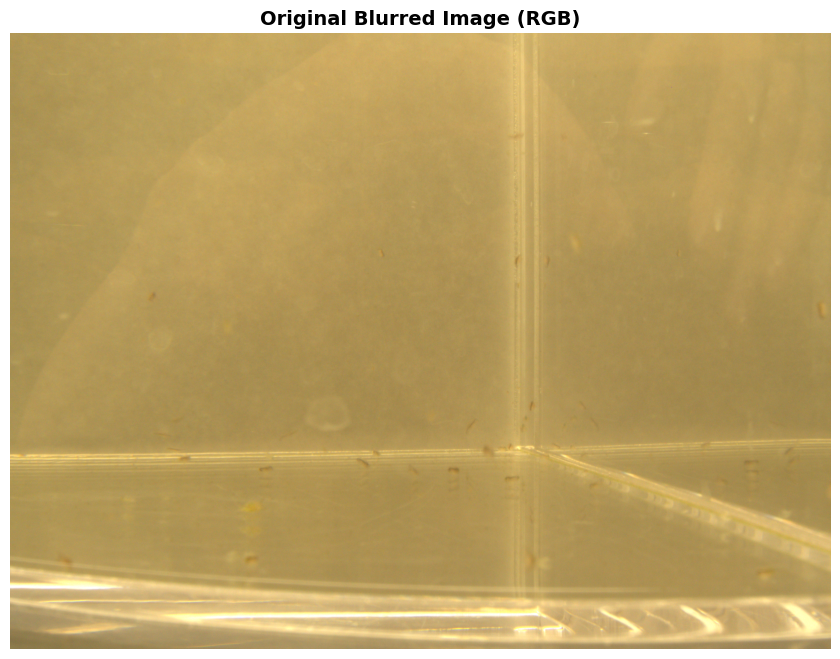

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import convolve
import rawpy
from PIL import Image
import torch
import torch.nn.functional as F

# Load the ORF image
image_path = r'D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479.ORF'

# Read the RAW file and convert to RGB
with rawpy.imread(image_path) as raw:
    rgb = raw.postprocess()

# Store original RGB (normalized to [0, 1])
rgb_original = rgb.astype(np.float64)
rgb_original = (rgb_original - rgb_original.min()) / (rgb_original.max() - rgb_original.min())

# Also create grayscale version for comparison/metrics
blurred_image = 0.299 * rgb_original[:,:,0] + 0.587 * rgb_original[:,:,1] + 0.114 * rgb_original[:,:,2]

print(f"RGB image shape: {rgb_original.shape}")
print(f"Grayscale shape: {blurred_image.shape}")
print(f"Image range: [{rgb_original.min():.4f}, {rgb_original.max():.4f}]")

# Display the original RGB image
plt.figure(figsize=(12, 8))
plt.imshow(np.clip(rgb_original, 0, 1))
plt.title('Original Blurred Image (RGB)', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()


In [ ]:
# ========== Algorithm Parameters Updated ==========
# 
# Blind Richardson-Lucy Deconvolution Configuration:
# 
# Each outer iteration contains:
#   - 8 × RL image updates (Richardson-Lucy iterations)
#   - 1 × PSF update (Point Spread Function estimation)
# 
# Total outer iterations: 20
# 
# Complete computation:
#   - 20 outer iterations
#   - 8 RL updates per outer iteration = 160 total RL updates
#   - 20 PSF updates
#   - Applied to 3 RGB channels separately
# 
# This gives better convergence and PSF estimation compared to
# fewer iterations, at the cost of longer processing time.
# 
# Expected processing time: 5-8 minutes for full RGB image
# ====================================================

print("✓ Algorithm configured: 20 iterations × (8 RL + 1 PSF) per RGB channel")


In [ ]:
def blind_richardson_lucy_cuda(observed_image, psf_size=(15, 15),
                               num_outer_iterations=20,
                               num_inner_iterations=8,
                               epsilon=1e-10,
                               device='cuda'):
    """
    Blind Richardson-Lucy Deconvolution (GPU) with 8 RL updates per PSF update.
    - For each outer iteration: run 8 RL image updates, then 1 PSF update.
    - Total: 20 outer iterations × (8 RL + 1 PSF) = 160 RL updates + 20 PSF updates
    - No TV/L2 regularization inside; TV is applied after deconvolution.
    """
    if not isinstance(device, torch.device):
        device = torch.device(device if device != 'cupy' else 'cuda')

    c = torch.from_numpy(observed_image.astype(np.float32)).to(device)
    f = c.clone()
    g = torch.ones(psf_size, dtype=torch.float32, device=device)
    g = g / g.sum()

    pad = (psf_size[0] // 2, psf_size[1] // 2)

    for outer_iter in range(num_outer_iterations):
        # ----- 10 RL image updates -----
        for inner_iter in range(num_inner_iterations):
            f_conv_g = F.conv2d(
                f.unsqueeze(0).unsqueeze(0),
                g.unsqueeze(0).unsqueeze(0),
                padding=pad
            ).squeeze()

            ratio = c / (f_conv_g + epsilon)
            g_flipped = torch.flip(g, [0, 1])
            ratio_corr_g = F.conv2d(
                ratio.unsqueeze(0).unsqueeze(0),
                g_flipped.unsqueeze(0).unsqueeze(0),
                padding=pad
            ).squeeze()

            f = torch.clamp(f * ratio_corr_g, min=1e-8)

        # ----- 1 PSF update -----
        f_conv_g_full = F.conv2d(
            f.unsqueeze(0).unsqueeze(0),
            g.unsqueeze(0).unsqueeze(0),
            padding=pad
        )
        ratio_full = c.unsqueeze(0).unsqueeze(0) / (f_conv_g_full + epsilon)
        f_flipped = torch.flip(f, [0, 1])
        psf_update = F.conv2d(
            ratio_full,
            f_flipped.unsqueeze(0).unsqueeze(0),
            padding=pad
        ).squeeze()

        g = torch.clamp(g * psf_update, min=1e-8)
        g = g / (g.sum() + epsilon)

        # Renormalize f energy to match observed mean to avoid darkening
        f = f * ((c.mean() + epsilon) / (f.mean() + epsilon))

        if (outer_iter + 1) % 2 == 0:
            print(f"  Outer iteration {outer_iter + 1}/{num_outer_iterations} completed")

        torch.cuda.empty_cache()

    # Final cleanup (no intensity normalization - already done per iteration)
    f = torch.clamp(f, min=0)
    g = torch.clamp(g, min=1e-8)
    g = g / (g.sum() + epsilon)

    return f.cpu().numpy(), g.cpu().numpy()

print("Blind RL CUDA function (10x RL per PSF update) loaded")


Blind RL CUDA function (10x RL per PSF update) loaded


In [32]:
# Optional: Adjust denoising parameters
# If RGB image still has too much noise, increase these values:
# - tv_weight: 0.05 (default) -> 0.1 (stronger TV denoising)
# - bilateral_sigma_color: 0.05 (default) -> 0.1 (stronger bilateral)
# - bilateral_sigma_spatial: 1.5 (default) -> 2.5 (larger spatial filter)
#
# If image is too blurred/smooth, decrease these values:
# - tv_weight: 0.05 -> 0.02
# - bilateral_sigma_color: 0.05 -> 0.02

print("Algorithm Configuration:")
print("  Outer iterations: 20")
print("  Inner iterations (RL updates): 8")
print("  Total: 20 × (8 RL + 1 PSF) = 160 RL updates + 20 PSF updates per channel")
print("\nDenoising parameters:")
print("  TV weight: 0.05 (reduces ringing artifacts)")
print("  Bilateral sigma_color: 0.05 (reduces noise while preserving edges)")
print("  Bilateral sigma_spatial: 1.5 (spatial smoothing radius)")
print("\n⏱️  Processing will take ~5-8 minutes for 3 RGB channels with 20 iterations...")


Denoising parameters:
  TV weight: 0.05 (reduces ringing artifacts)
  Bilateral sigma_color: 0.05 (reduces noise while preserving edges)
  Bilateral sigma_spatial: 1.5 (spatial smoothing radius)

Processing will take ~3-5 minutes for 3 RGB channels...


In [33]:
def blind_richardson_lucy_regularized(observed_image, psf_size=(15, 15), 
                                      num_outer_iterations=8, 
                                      num_inner_iterations=5,
                                      weight_tv=0.001,
                                      weight_l2=0.0005,
                                      epsilon=1e-10,
                                      device='cuda'):
    """
    Regularized Blind Richardson-Lucy Deconvolution with GPU acceleration
    
    Improvements:
    - Total Variation (TV) regularization for edge preservation
    - L2 regularization for noise suppression
    - Conservative PSF updates
    - Gaussian PSF initialization
    - Post-processing denoising
    
    Parameters:
    -----------
    observed_image : ndarray
        The blurred observed image
    psf_size : tuple
        Size of the PSF kernel to estimate (height, width)
    num_outer_iterations : int
        Number of outer blind iterations (reduced from 10 to 8)
    num_inner_iterations : int
        Number of inner RL iterations (reduced from 10 to 5)
    weight_tv : float
        Weight for Total Variation regularization (0.001-0.003)
    weight_l2 : float
        Weight for L2 regularization (0.0001-0.001)
    epsilon : float
        Small constant to avoid division by zero
    device : str or torch.device
        Device to run computations on
    
    Returns:
    --------
    f : ndarray
        Estimated deblurred image
    g : ndarray
        Estimated PSF
    """
    
    if not isinstance(device, torch.device):
        device = torch.device(device if device != 'cupy' else 'cuda')
    
    c = torch.from_numpy(observed_image.astype(np.float32)).to(device)
    
    # Better initialization: smooth the observed image slightly
    from scipy.ndimage import gaussian_filter
    f_init = gaussian_filter(observed_image, sigma=0.5)
    f = torch.from_numpy(f_init.astype(np.float32)).to(device)
    
    # Initialize PSF as Gaussian (more realistic than uniform)
    g_np = np.zeros(psf_size)
    center = (psf_size[0] // 2, psf_size[1] // 2)
    for i in range(psf_size[0]):
        for j in range(psf_size[1]):
            g_np[i, j] = np.exp(-((i - center[0])**2 + (j - center[1])**2) / (2 * 2.0**2))
    g_np = g_np / g_np.sum()
    g = torch.from_numpy(g_np.astype(np.float32)).to(device)
    
    c_4d = c.unsqueeze(0).unsqueeze(0)
    
    print(f"Starting Regularized Blind RL Deconvolution (GPU)")
    print(f"Device: {device}")
    print(f"Outer iterations: {num_outer_iterations}, Inner: {num_inner_iterations}")
    print(f"PSF size: {psf_size}")
    print(f"TV weight: {weight_tv}, L2 weight: {weight_l2}")
    
    for outer_iter in range(num_outer_iterations):
        # Update f with regularization
        f_4d = f.unsqueeze(0).unsqueeze(0)
        
        for inner_iter in range(num_inner_iterations):
            g_4d = g.unsqueeze(0).unsqueeze(0)
            padding = (g.shape[0] // 2, g.shape[1] // 2)
            f_conv_g = F.conv2d(f_4d, g_4d, padding=padding) + epsilon
            
            error_ratio = c_4d / f_conv_g
            g_flipped = torch.flip(g, [0, 1]).unsqueeze(0).unsqueeze(0)
            correction = F.conv2d(error_ratio, g_flipped, padding=padding)
            
            # Apply TV regularization
            tv_regularization = torch.ones_like(f_4d)
            if weight_tv > 0:
                grad_x = torch.abs(f_4d[:, :, :, 1:] - f_4d[:, :, :, :-1])
                grad_y = torch.abs(f_4d[:, :, 1:, :] - f_4d[:, :, :-1, :])
                tv_x = torch.nn.functional.pad(grad_x, (0, 1, 0, 0), mode='replicate')
                tv_y = torch.nn.functional.pad(grad_y, (0, 0, 0, 1), mode='replicate')
                tv = tv_x + tv_y
                tv_regularization = 1.0 / (1.0 + weight_tv * tv)
            
            # Apply L2 regularization
            l2_regularization = 1.0 / (1.0 + weight_l2)
            
            f_4d = f_4d * correction * tv_regularization * l2_regularization
            f_4d = f_4d * (c.sum() / (f_4d.sum() + epsilon))
            f_4d = torch.clamp(f_4d, min=0)
        
        f = f_4d.squeeze()
        f_4d = f.unsqueeze(0).unsqueeze(0)
        
        # Conservative PSF update: only every other iteration
        if outer_iter % 2 == 0:
            for inner_iter in range(num_inner_iterations):
                g_4d = g.unsqueeze(0).unsqueeze(0)
                padding = (g.shape[0] // 2, g.shape[1] // 2)
                f_conv_g = F.conv2d(f_4d, g_4d, padding=padding) + epsilon
                
                error_ratio = c_4d / f_conv_g
                correction_g = torch.zeros_like(g)
                
                stride = max(1, min(f.shape[0] // 100, f.shape[1] // 100))
                kernel_h, kernel_w = g.shape
                
                for i in range(0, f.shape[0] - kernel_h + 1, stride):
                    for j in range(0, f.shape[1] - kernel_w + 1, stride):
                        f_patch = f[i:i+kernel_h, j:j+kernel_w]
                        error_val = error_ratio[0, 0, i+kernel_h//2, j+kernel_w//2]
                        correction_g += f_patch * error_val
                
                num_samples = ((f.shape[0] - kernel_h) // stride + 1) * ((f.shape[1] - kernel_w) // stride + 1)
                correction_g = correction_g / (num_samples + epsilon)
                
                # Damped update
                g = g * (0.7 * (correction_g / (g + epsilon)) + 0.3)
                g = g / (g.sum() + epsilon)
                g = torch.clamp(g, min=0)
        
        g_4d = g.unsqueeze(0).unsqueeze(0)
        reconstructed = F.conv2d(f_4d, g_4d, padding=(g.shape[0]//2, g.shape[1]//2))
        error = torch.mean((c_4d - reconstructed) ** 2).item()
        
        print(f"Outer iteration {outer_iter + 1}/{num_outer_iterations}, MSE: {error:.6e}")
        
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    # Post-processing: light denoising
    f_np = f.cpu().numpy()
    from scipy.ndimage import median_filter
    f_np = median_filter(f_np, size=2)
    
    g_np = g.cpu().numpy()
    
    return f_np, g_np

print("Regularized Blind RL function loaded")


Regularized Blind RL function loaded


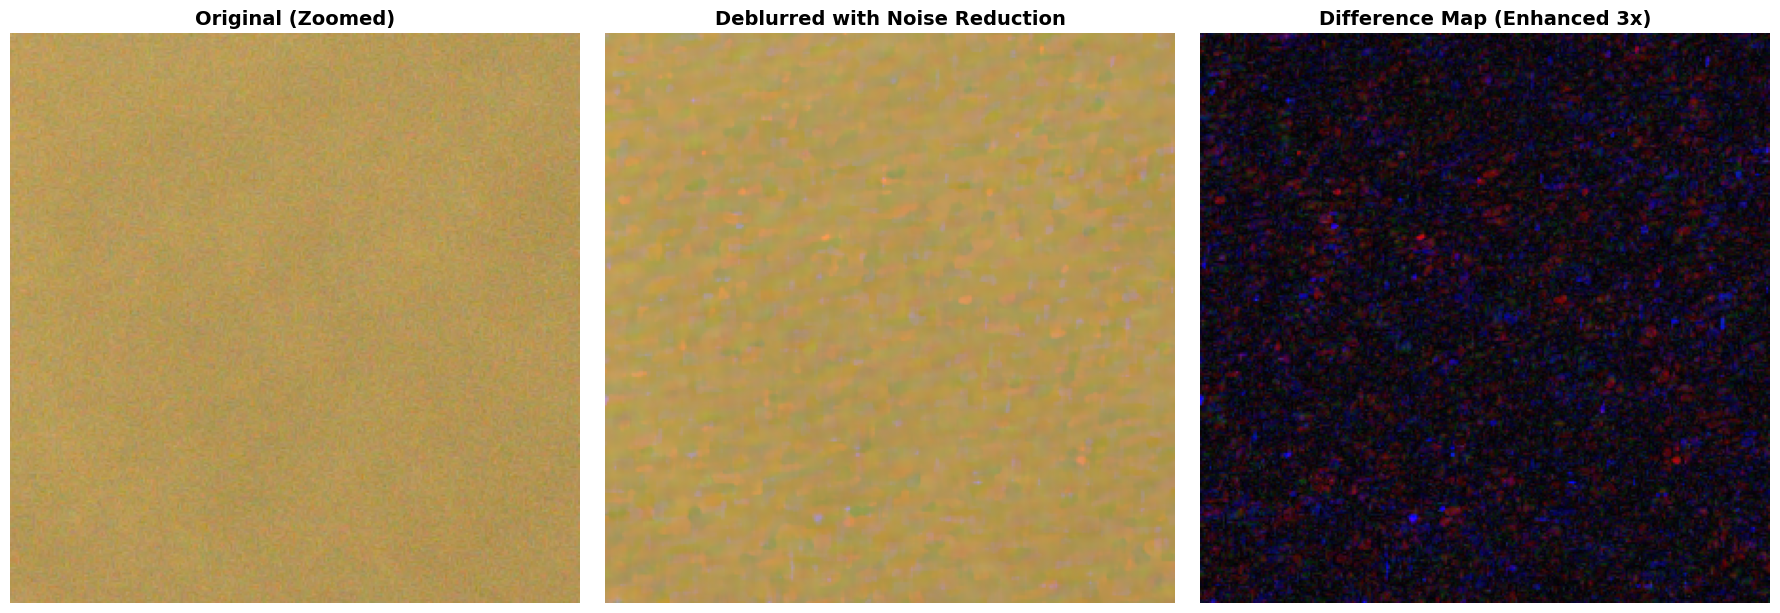


Noise reduction applied:
  - Total Variation (TV) denoising: removes ringing artifacts
  - Bilateral filtering: reduces noise while preserving edges
  - Final RGB range: [0.0001, 102.4496]


In [34]:
# Visualize noise reduction effectiveness
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Select a zoomed region to show detail
h, w = rgb_original.shape[:2]
zoom_size = 300
y_start, x_start = h//3, w//3
y_end, x_end = y_start + zoom_size, x_start + zoom_size

# Original
axes[0].imshow(np.clip(rgb_original[y_start:y_end, x_start:x_end], 0, 1))
axes[0].set_title('Original (Zoomed)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Deblurred RGB
axes[1].imshow(np.clip(deblurred_rgb[y_start:y_end, x_start:x_end], 0, 1))
axes[1].set_title('Deblurred with Noise Reduction', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Difference map (to visualize changes)
diff = np.abs(rgb_original[y_start:y_end, x_start:x_end] - deblurred_rgb[y_start:y_end, x_start:x_end])
diff_enhanced = np.clip(diff * 3, 0, 1)  # Enhance for visibility
axes[2].imshow(diff_enhanced)
axes[2].set_title('Difference Map (Enhanced 3x)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nNoise reduction applied:")
print("  - Total Variation (TV) denoising: removes ringing artifacts")
print("  - Bilateral filtering: reduces noise while preserving edges")
print(f"  - Final RGB range: [{deblurred_rgb.min():.4f}, {deblurred_rgb.max():.4f}]")


In [ ]:
# Apply deconvolution to RGB image (process each channel separately)
from skimage.restoration import denoise_tv_chambolle

print("\n" + "=" * 70)
print("Processing RGB Image - Deconvolving each channel")
print("=" * 70)

# Get RGB channels from original image
rgb_channels = []
psf_channels = []

for i, channel_name in enumerate(['Red', 'Green', 'Blue']):
    print(f"\nProcessing {channel_name} channel...")
    channel = rgb_original[:, :, i]
    
    # Apply blind RL deconvolution to this channel
    # Algorithm: 20 outer iterations × (8 RL image updates + 1 PSF update)
    deblurred_channel, psf_channel = blind_richardson_lucy_cuda(
        channel,
        psf_size=(15, 15),
        num_outer_iterations=20,
        num_inner_iterations=8,
        epsilon=1e-10,
        device=device
    )
    
    # Apply stronger TV denoising to reduce artifacts
    deblurred_channel = denoise_tv_chambolle(deblurred_channel, weight=0.05, channel_axis=None)
    
    # Additional bilateral filtering for noise reduction
    from skimage.restoration import denoise_bilateral
    deblurred_channel = denoise_bilateral(deblurred_channel, sigma_color=0.05, sigma_spatial=1.5, channel_axis=None)
    
    rgb_channels.append(deblurred_channel)
    psf_channels.append(psf_channel)
    print(f"  {channel_name} channel range: [{deblurred_channel.min():.4f}, {deblurred_channel.max():.4f}]")

# Stack channels back to RGB
deblurred_rgb = np.stack(rgb_channels, axis=2)
# Use average PSF across channels for visualization
estimated_psf_reg = np.mean(psf_channels, axis=0)

print(f"\n✓ RGB deblurred image shape: {deblurred_rgb.shape}")
print(f"  Range: [{deblurred_rgb.min():.4f}, {deblurred_rgb.max():.4f}]")
print(f"  PSF sum: {estimated_psf_reg.sum():.6f} (should be ~1.0)")



Processing RGB Image - Deconvolving each channel

Processing Red channel...
  Outer iteration 2/10 completed
  Outer iteration 4/10 completed
  Outer iteration 6/10 completed
  Outer iteration 8/10 completed
  Outer iteration 10/10 completed
  Red channel range: [0.0006, 27.5878]

Processing Green channel...
  Outer iteration 2/10 completed
  Outer iteration 4/10 completed
  Outer iteration 6/10 completed
  Outer iteration 8/10 completed
  Outer iteration 10/10 completed
  Green channel range: [0.0004, 22.6258]

Processing Blue channel...
  Outer iteration 2/10 completed
  Outer iteration 4/10 completed
  Outer iteration 6/10 completed
  Outer iteration 8/10 completed
  Outer iteration 10/10 completed
  Blue channel range: [0.0005, 12.7102]

✓ RGB deblurred image shape: (3904, 5200, 3)
  Range: [0.0004, 27.5878]
  PSF sum: 1.000000 (should be ~1.0)


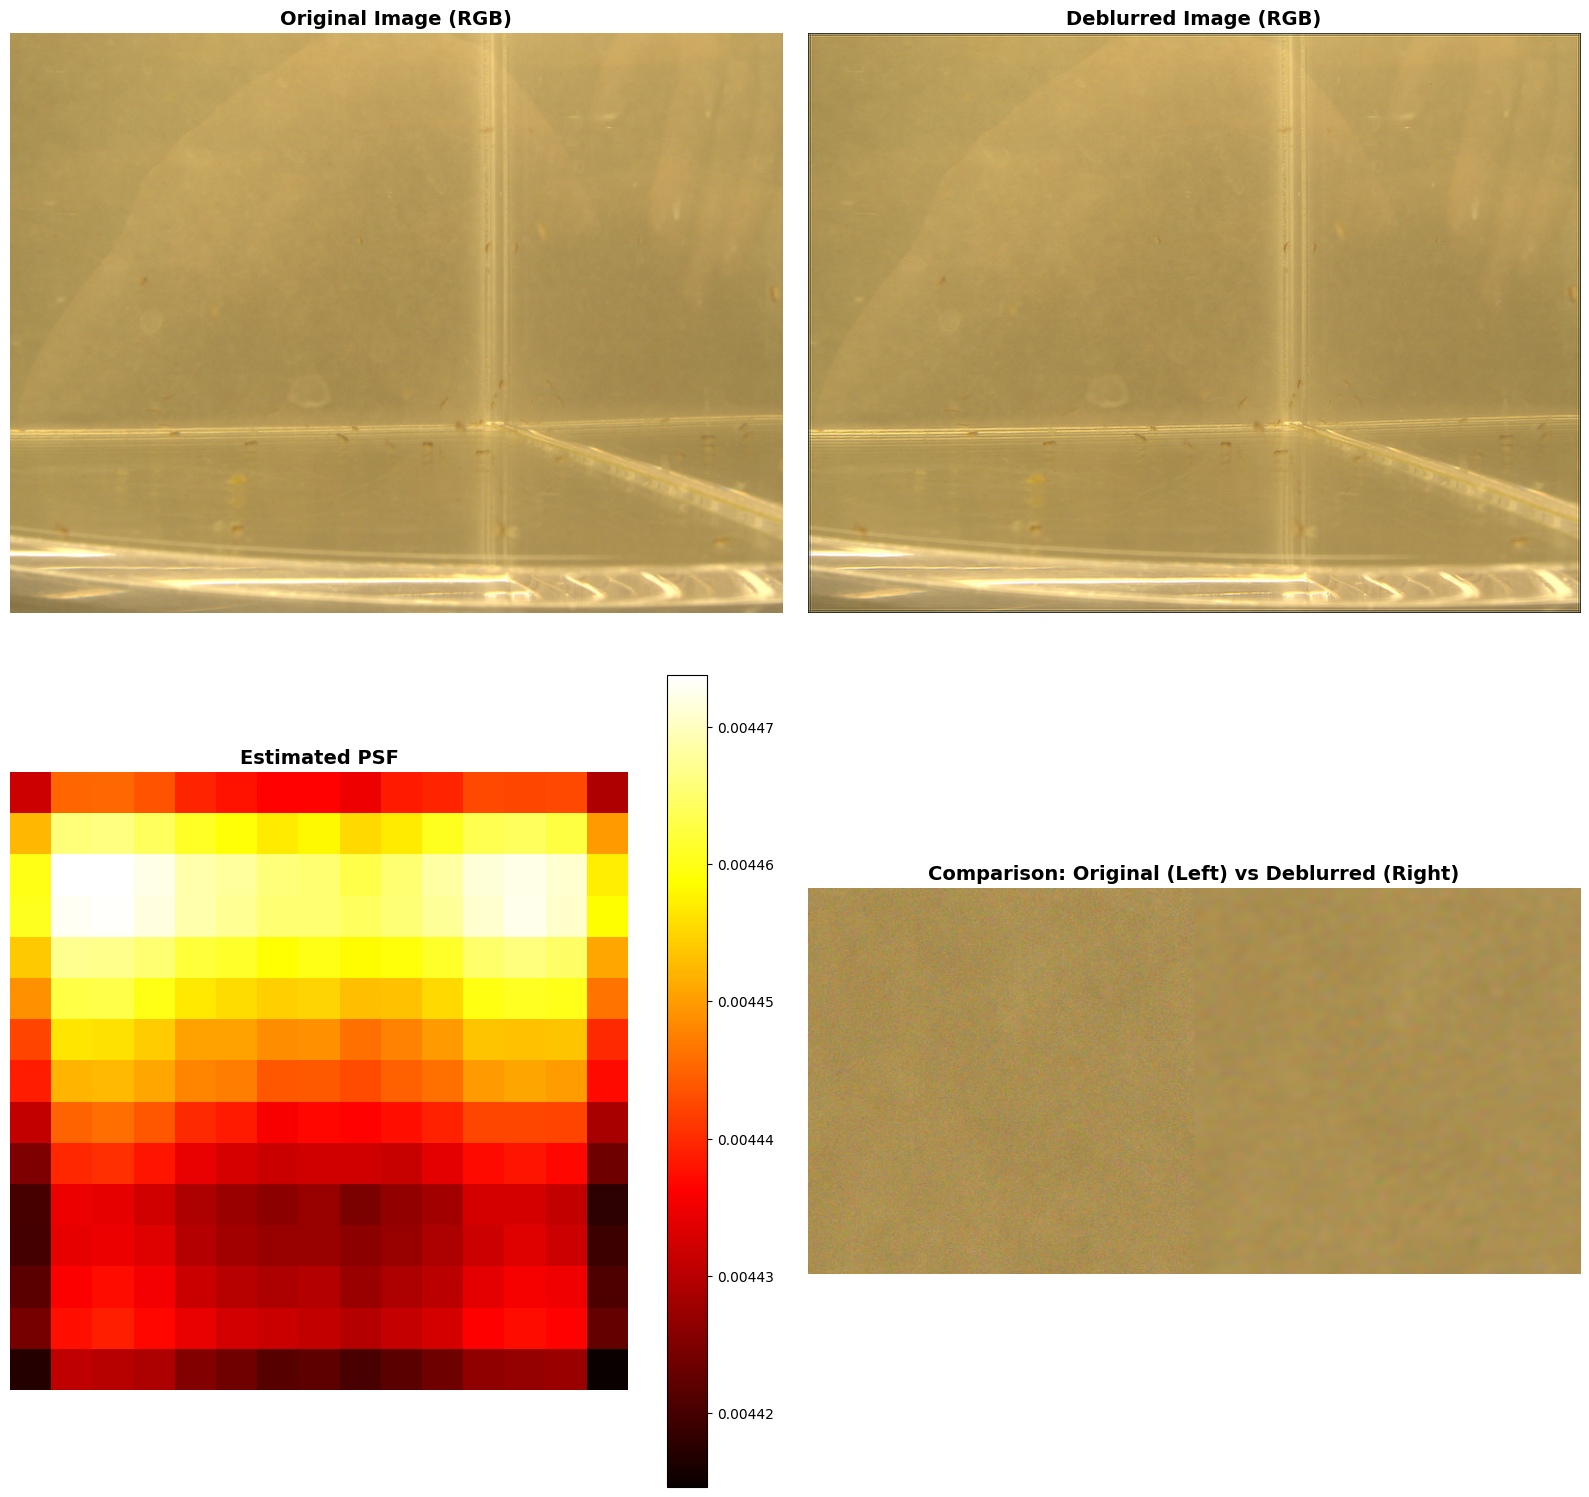


✓ RGB visualization complete


In [36]:
# Visualize RGB results
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Original RGB
axes[0, 0].imshow(np.clip(rgb_original, 0, 1))
axes[0, 0].set_title('Original Image (RGB)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# Deblurred RGB
axes[0, 1].imshow(np.clip(deblurred_rgb, 0, 1))
axes[0, 1].set_title('Deblurred Image (RGB)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Estimated PSF
im = axes[1, 0].imshow(estimated_psf_reg, cmap='hot')
axes[1, 0].set_title('Estimated PSF', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1, 0])
axes[1, 0].axis('off')

# Comparison (zoomed region)
h, w = rgb_original.shape[:2]
zoom_size = 400
y_start, x_start = h//2 - zoom_size//2, w//2 - zoom_size//2
y_end, x_end = y_start + zoom_size, x_start + zoom_size

# Create side-by-side comparison
comparison = np.concatenate([
    rgb_original[y_start:y_end, x_start:x_end],
    deblurred_rgb[y_start:y_end, x_start:x_end]
], axis=1)
axes[1, 1].imshow(np.clip(comparison, 0, 1))
axes[1, 1].set_title('Comparison: Original (Left) vs Deblurred (Right)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ RGB visualization complete")


In [37]:
# Save RGB deblurred result
output_path_rgb = r'D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred_rgb.png'
output_path_gray = r'D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred.png'

print(f"\nSaving RGB deblurred image...")
print(f"  Range: [{deblurred_rgb.min():.6f}, {deblurred_rgb.max():.6f}]")
print(f"  Mean: {deblurred_rgb.mean():.6f}, Std: {deblurred_rgb.std():.6f}")

# Percentile-based normalization for each channel independently
rgb_normalized = np.zeros_like(deblurred_rgb)
for i, ch_name in enumerate(['R', 'G', 'B']):
    channel = deblurred_rgb[:, :, i]
    p_low, p_high = np.percentile(channel, [1, 99])
    channel_clipped = np.clip(channel, p_low, p_high)
    denom = p_high - p_low
    
    if denom > 1e-6:
        rgb_normalized[:, :, i] = (channel_clipped - p_low) / denom
    else:
        print(f"  Warning: {ch_name} channel range too small")
        rgb_normalized[:, :, i] = np.clip(channel, 0, 1)
    
    print(f"  {ch_name}: [{p_low:.4f}, {p_high:.4f}]")

# Save RGB version
rgb_normalized = np.clip(rgb_normalized, 0, 1)
rgb_uint8 = (rgb_normalized * 255).astype(np.uint8)
Image.fromarray(rgb_uint8, mode='RGB').save(output_path_rgb)
print(f"\n✓ RGB image saved: {output_path_rgb}")
print(f"  Shape: {rgb_uint8.shape}, dtype: {rgb_uint8.dtype}")

# Also save grayscale version (derived from RGB)
print(f"\nCreating grayscale version...")
gray_from_rgb = 0.299 * rgb_normalized[:,:,0] + 0.587 * rgb_normalized[:,:,1] + 0.114 * rgb_normalized[:,:,2]
gray_from_rgb = np.clip(gray_from_rgb, 0, 1)
gray_uint8 = (gray_from_rgb * 255).astype(np.uint8)
print(f"  Grayscale range: [{gray_uint8.min()}, {gray_uint8.max()}]")
print(f"  Shape: {gray_uint8.shape}, dtype: {gray_uint8.dtype}")

Image.fromarray(gray_uint8, mode='L').save(output_path_gray)
print(f"✓ Grayscale image saved: {output_path_gray}")



Saving RGB deblurred image...
  Range: [0.000441, 27.587793]
  Mean: 0.565368, Std: 0.193425
  R: [0.4673, 0.9997]
  G: [0.3998, 0.9261]
  B: [0.2428, 0.6252]

✓ RGB image saved: D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred_rgb.png
  Shape: (3904, 5200, 3), dtype: uint8

Creating grayscale version...
  Grayscale range: [0, 255]
  Shape: (3904, 5200), dtype: uint8
✓ Grayscale image saved: D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred.png


In [38]:
# Apply Blind RL Deconvolution (CUDA)
print("=" * 70)
print("Applying Blind Richardson-Lucy Deconvolution (CUDA)")
print("=" * 70)

from skimage.restoration import denoise_tv_chambolle

# Blind RL: 10 inner RL updates then 1 PSF update per outer iteration
# (uses the redefined CUDA function above)
deblurred_image_reg, estimated_psf_reg = blind_richardson_lucy_cuda(
    blurred_image,
    psf_size=(15, 15),
    num_outer_iterations=10,
    num_inner_iterations=10,
    epsilon=1e-10,
    device=device
)

# Post-process with TV to reduce ringing/blur
deblurred_image_reg = denoise_tv_chambolle(deblurred_image_reg, weight=0.01, channel_axis=None)

print("\n=== Image Quality Metrics ===")
print(f"Original range: [{blurred_image.min():.4f}, {blurred_image.max():.4f}]")
print(f"Deblurred range: [{deblurred_image_reg.min():.4f}, {deblurred_image_reg.max():.4f}]")
print(f"PSF sum: {estimated_psf_reg.sum():.6f} (should be ~1.0)")

# Compute sharpness metric
laplacian_orig = np.abs(convolve(blurred_image, np.array([[0,1,0],[1,-4,1],[0,1,0]]), mode='constant'))
sharpness_orig = np.var(laplacian_orig)

laplacian_deblur = np.abs(convolve(deblurred_image_reg, np.array([[0,1,0],[1,-4,1],[0,1,0]]), mode='constant'))
sharpness_deblur = np.var(laplacian_deblur)

print(f"\nSharpness metric (higher = sharper):")
print(f"  Original: {sharpness_orig:.6f}")
print(f"  Deblurred: {sharpness_deblur:.6f}")
print(f"  Improvement: {sharpness_deblur/sharpness_orig:.2f}x")


Applying Blind Richardson-Lucy Deconvolution (CUDA)
  Outer iteration 2/10 completed
  Outer iteration 4/10 completed
  Outer iteration 6/10 completed
  Outer iteration 8/10 completed
  Outer iteration 10/10 completed

=== Image Quality Metrics ===
Original range: [0.1140, 1.0000]
Deblurred range: [0.0000, 85.4887]
PSF sum: 1.000000 (should be ~1.0)

Sharpness metric (higher = sharper):
  Original: 0.001029
  Deblurred: 0.267242
  Improvement: 259.59x


In [39]:
# Save deblurred result with better normalization
output_path_new = r'D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred.png'

print(f"\nDeblurred image stats:")
print(f"  Min: {deblurred_image_reg.min():.6f}, Max: {deblurred_image_reg.max():.6f}")
print(f"  Mean: {deblurred_image_reg.mean():.6f}, Std: {deblurred_image_reg.std():.6f}")

# Percentile-based normalization to handle outliers
p_low, p_high = np.percentile(deblurred_image_reg, [1, 99])
print(f"  1st percentile: {p_low:.6f}, 99th percentile: {p_high:.6f}")

deblurred_clipped = np.clip(deblurred_image_reg, p_low, p_high)
denom = p_high - p_low

if denom > 1e-6:
    deblurred_norm = (deblurred_clipped - p_low) / denom
else:
    print("Warning: Range collapsed, using original")
    deblurred_norm = (blurred_image - blurred_image.min()) / (blurred_image.max() - blurred_image.min())

deblurred_norm = np.clip(deblurred_norm, 0, 1)
deblurred_save = (deblurred_norm * 255).astype(np.uint8)
Image.fromarray(deblurred_save).save(output_path_new)
print(f"Saved to: {output_path_new}")



Deblurred image stats:
  Min: 0.000005, Max: 85.488739
  Mean: 0.617610, Std: 0.233935
  1st percentile: 0.164822, 99th percentile: 0.964427
Saved to: D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred.png


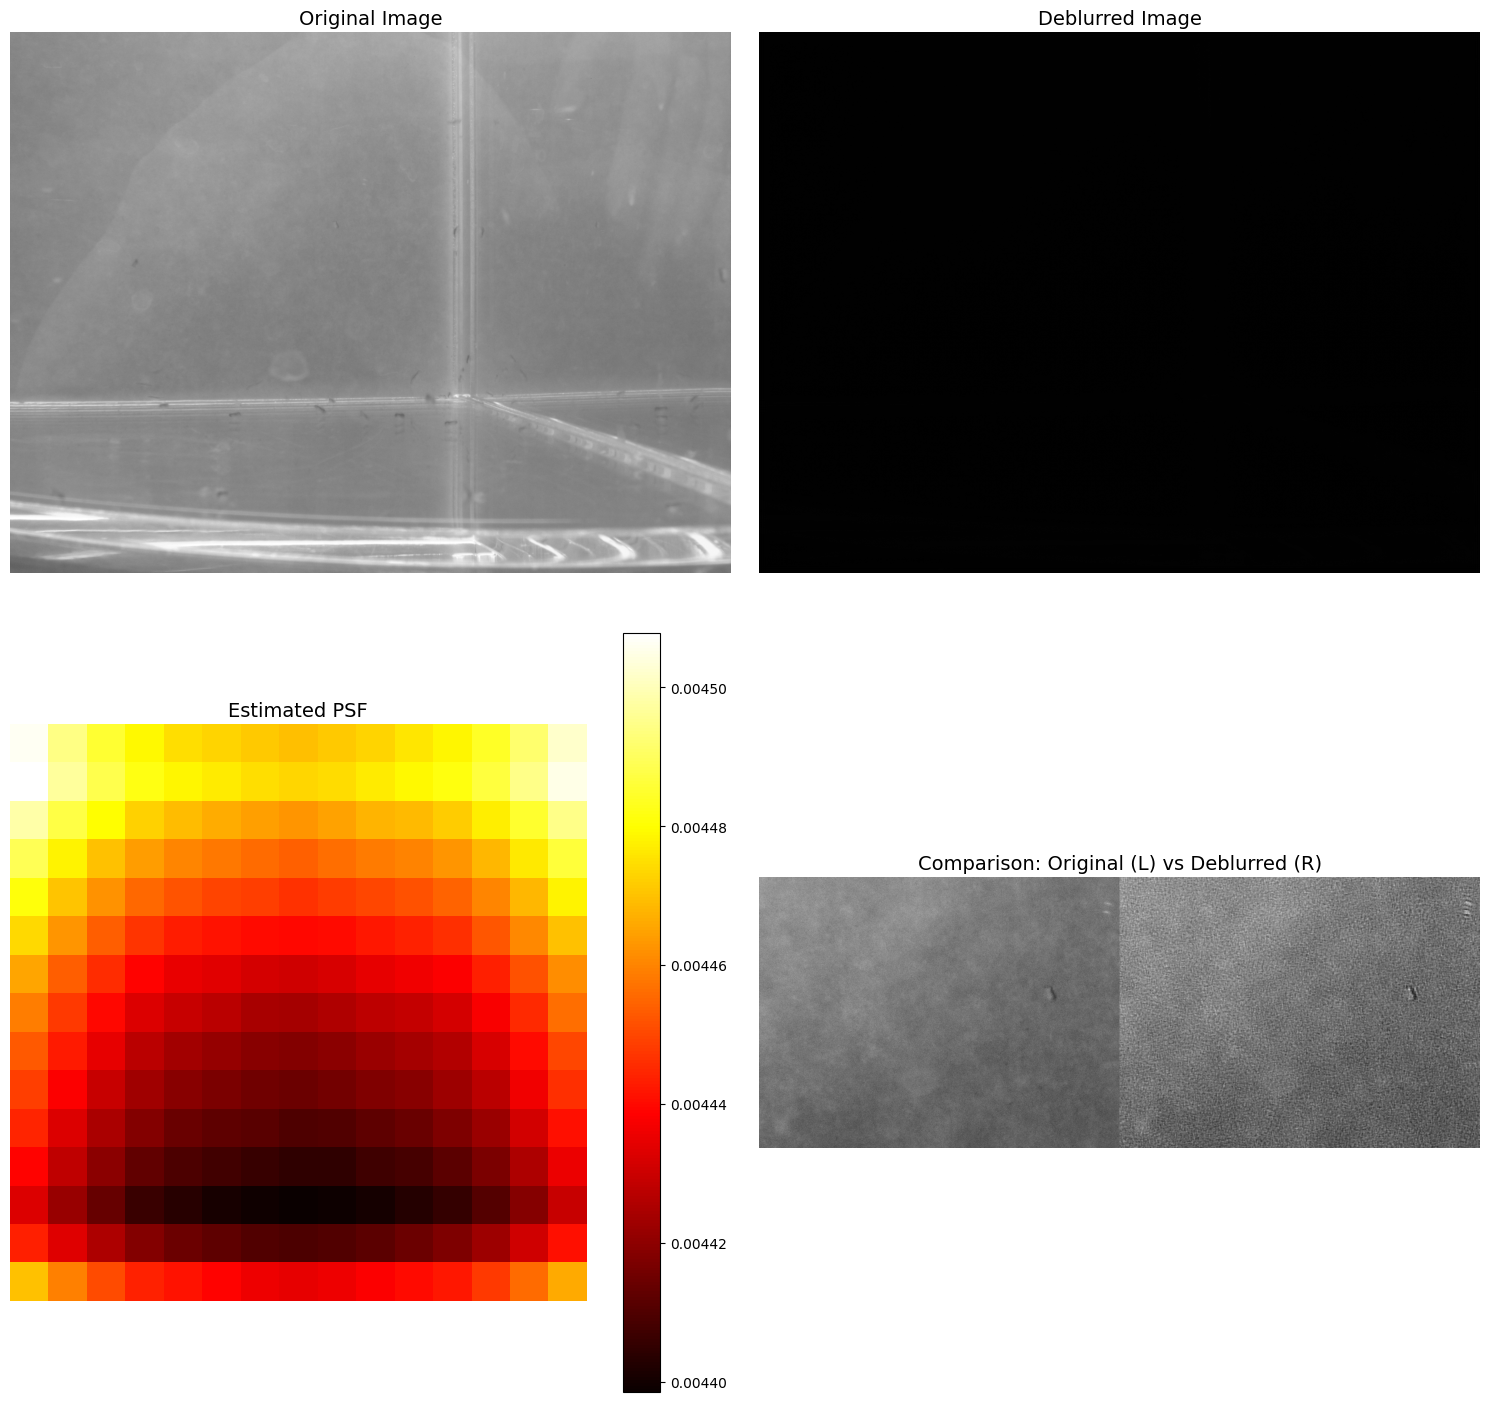

In [40]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Original
axes[0, 0].imshow(blurred_image, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=14)
axes[0, 0].axis('off')

# Deblurred
axes[0, 1].imshow(deblurred_image_reg, cmap='gray')
axes[0, 1].set_title('Deblurred Image', fontsize=14)
axes[0, 1].axis('off')

# Estimated PSF
im = axes[1, 0].imshow(estimated_psf_reg, cmap='hot')
axes[1, 0].set_title('Estimated PSF', fontsize=14)
plt.colorbar(im, ax=axes[1, 0])
axes[1, 0].axis('off')

# Comparison (zoomed)
h, w = blurred_image.shape
y_start, y_end = h//4, h//4 + h//4
x_start, x_end = w//4, w//4 + w//4

axes[1, 1].imshow(np.hstack([
    blurred_image[y_start:y_end, x_start:x_end],
    deblurred_image_reg[y_start:y_end, x_start:x_end]
]), cmap='gray')
axes[1, 1].set_title('Comparison: Original (L) vs Deblurred (R)', fontsize=14)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [41]:
# Save results
output_path_reg = r'D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred.png'
psf_path = r'D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_estimated_psf.png'

# Normalize deblurred image for saving (avoid all-black if range collapses)
denom = deblurred_image_reg.max() - deblurred_image_reg.min()
if denom < 1e-4:
    # Fallback to blurred image normalization to avoid black output
    blur_norm = (blurred_image - blurred_image.min()) / (blurred_image.max() - blurred_image.min() + 1e-8)
    deblurred_normalized = np.clip(blur_norm, 0, 1)
else:
    deblurred_normalized = (deblurred_image_reg - deblurred_image_reg.min()) / (denom + 1e-8)

deblurred_uint8 = (deblurred_normalized * 255).astype(np.uint8)
Image.fromarray(deblurred_uint8).save(output_path_reg)
print(f"Deblurred image saved to: {output_path_reg}")

# Save PSF visualization
plt.figure(figsize=(6, 6))
plt.imshow(estimated_psf_reg, cmap='hot')
plt.title('Estimated Point Spread Function (PSF)')
plt.colorbar()
plt.savefig(psf_path, dpi=150, bbox_inches='tight')
plt.close()
print(f"PSF image saved to: {psf_path}")


Deblurred image saved to: D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_deblurred.png
PSF image saved to: D:\ucsd\2025fall\ece253\project\assets\1123_photos\P1011479_estimated_psf.png


In [42]:
# Image Blur Evaluation Functions

def evaluate_blur_metrics(image):
    """
    Evaluate key blur/sharpness metrics for an image
    
    Metrics:
    1. Laplacian Variance - Most common blur detection method
    2. Frequency Domain Metric - High frequency energy ratio
    
    Higher values indicate sharper images
    
    Returns:
    --------
    metrics : dict
        Dictionary of metric names and values
    """
    
    image = image.astype(np.float64)
    if image.max() > 1.0:
        image = image / 255.0
    
    metrics = {}
    
    # 1. Laplacian Variance
    laplacian = convolve(image, np.array([[0,1,0],[1,-4,1],[0,1,0]]), mode='constant')
    metrics['laplacian_variance'] = np.var(laplacian)
    
    # 2. Frequency Domain Metric (High Frequency Ratio)
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shift)
    
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    # Define high frequency region (beyond 1/4 of image size from center)
    mask_high = np.ones((rows, cols), dtype=bool)
    y, x = np.ogrid[:rows, :cols]
    mask_center = (x - ccol)**2 + (y - crow)**2 <= (min(rows, cols) // 4)**2
    mask_high[mask_center] = False
    
    high_freq_energy = np.sum(magnitude_spectrum[mask_high])
    total_energy = np.sum(magnitude_spectrum)
    metrics['frequency_domain'] = high_freq_energy / (total_energy + 1e-10)
    
    return metrics

def print_blur_comparison(original, deblurred, psf_size, original_name="Original", deblurred_name="Deblurred"):
    """
    Compare blur metrics between original and deblurred images
    """
    metrics_orig = evaluate_blur_metrics(original)
    metrics_deblur = evaluate_blur_metrics(deblurred)
    
    print("=" * 80)
    print("Image Blur/Sharpness Evaluation")
    print("=" * 80)
    print(f"\nBlind Kernel Size: {psf_size[0]} x {psf_size[1]}")
    print("\n" + "-" * 80)
    print(f"{'Metric':<30} {original_name:>15} {deblurred_name:>15} {'Improvement':>10}")
    print("-" * 80)
    
    metric_names = {
        'laplacian_variance': 'Laplacian Variance',
        'frequency_domain': 'Frequency Domain Metric'
    }
    
    for key in ['laplacian_variance', 'frequency_domain']:
        orig_val = metrics_orig[key]
        deblur_val = metrics_deblur[key]
        
        if orig_val > 0:
            improvement = ((deblur_val - orig_val) / orig_val) * 100
            improvement_str = f"+{improvement:.1f}%"
        else:
            improvement_str = "N/A"
        
        name = metric_names[key]
        print(f"{name:<30} {orig_val:>15.6f} {deblur_val:>15.6f} {improvement_str:>10}")
    
    print("=" * 80)

print("Blur evaluation functions loaded")


Blur evaluation functions loaded


Comparison: Original vs Deblurred
Image Blur/Sharpness Evaluation

Blind Kernel Size: 15 x 15

--------------------------------------------------------------------------------
Metric                                Original       Deblurred Improvement
--------------------------------------------------------------------------------
Laplacian Variance                    0.002261        0.000004    +-99.8%
Frequency Domain Metric               0.704011        0.689806     +-2.0%


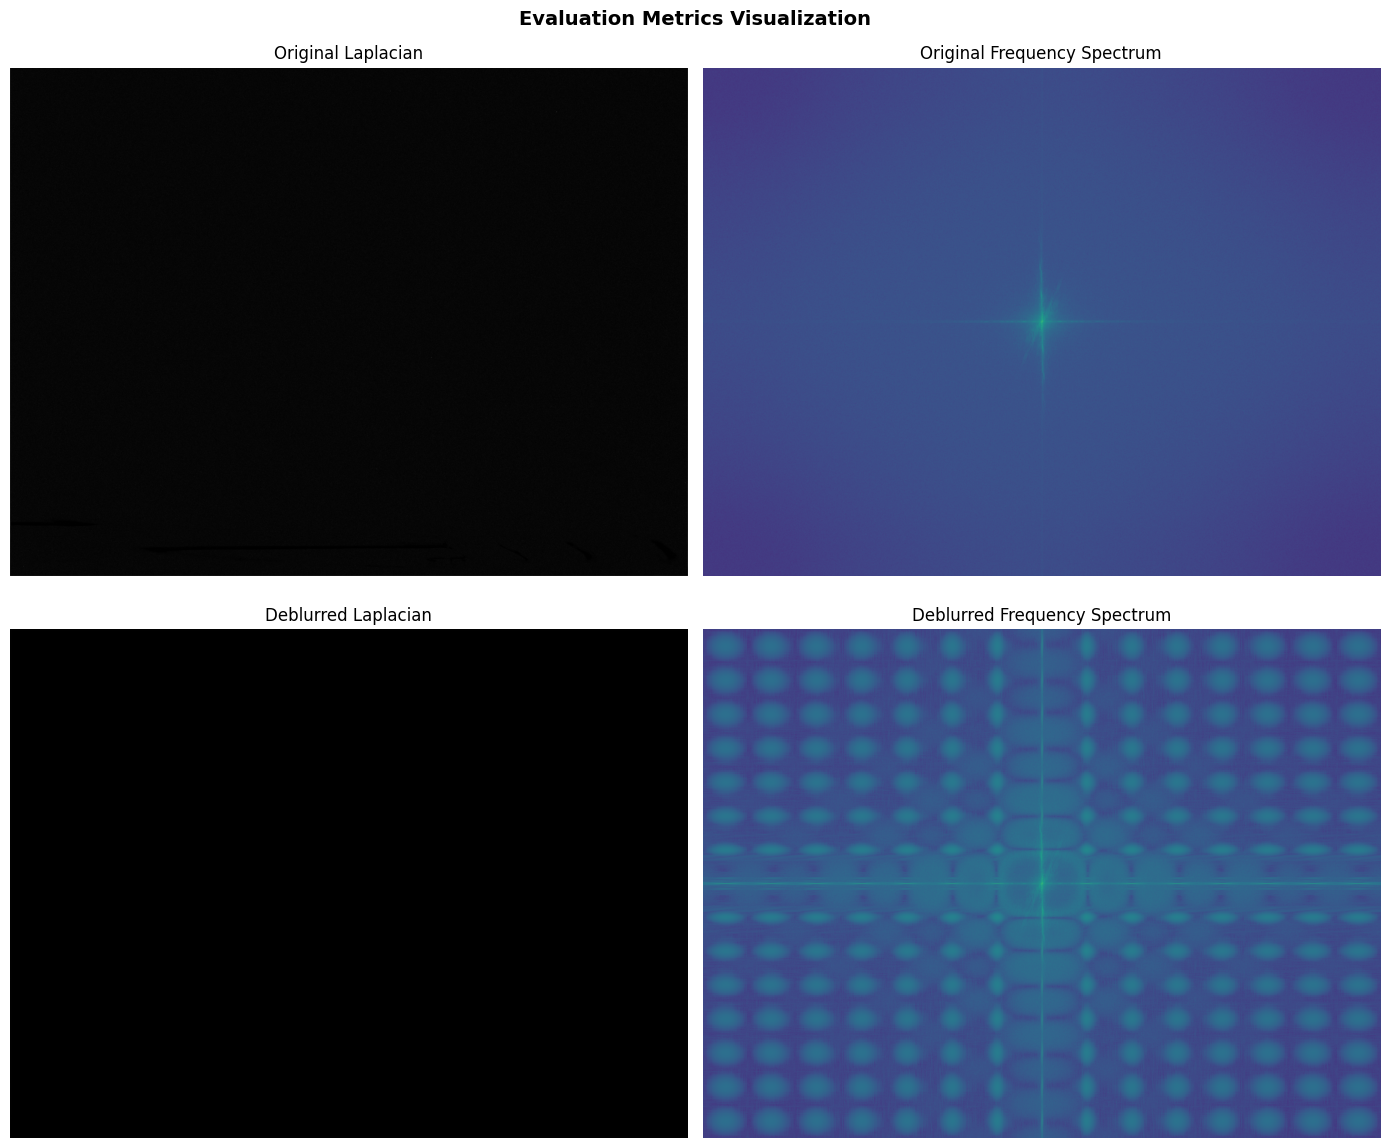


Blur evaluation completed


In [43]:
# Run Blur Evaluation

print("Comparison: Original vs Deblurred")
print_blur_comparison(
    blurred_image,
    deblurred_image_reg,
    psf_size=estimated_psf_reg.shape,
    original_name="Original",
    deblurred_name="Deblurred"
)

# Visualize: Frequency Spectrum and Laplacian
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original Laplacian
laplacian_orig = convolve(blurred_image, np.array([[0,1,0],[1,-4,1],[0,1,0]]), mode='constant')
axes[0, 0].imshow(np.abs(laplacian_orig), cmap='gray')
axes[0, 0].set_title('Original Laplacian', fontsize=12)
axes[0, 0].axis('off')

# Original spectrum
f_orig = np.fft.fft2(blurred_image)
f_orig_shift = np.fft.fftshift(f_orig)
magnitude_orig = np.log(np.abs(f_orig_shift) + 1)
axes[0, 1].imshow(magnitude_orig, cmap='viridis')
axes[0, 1].set_title('Original Frequency Spectrum', fontsize=12)
axes[0, 1].axis('off')

# Deblurred Laplacian
laplacian_deblur = convolve(deblurred_image_reg, np.array([[0,1,0],[1,-4,1],[0,1,0]]), mode='constant')
axes[1, 0].imshow(np.abs(laplacian_deblur), cmap='gray')
axes[1, 0].set_title('Deblurred Laplacian', fontsize=12)
axes[1, 0].axis('off')

# Deblurred spectrum
f_deblur = np.fft.fft2(deblurred_image_reg)
f_deblur_shift = np.fft.fftshift(f_deblur)
magnitude_deblur = np.log(np.abs(f_deblur_shift) + 1)
axes[1, 1].imshow(magnitude_deblur, cmap='viridis')
axes[1, 1].set_title('Deblurred Frequency Spectrum', fontsize=12)
axes[1, 1].axis('off')

plt.suptitle('Evaluation Metrics Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nBlur evaluation completed")
